# Denoising with the deep decoder

The code below demonstrates the denoising performance on an example image.

In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Define path to repo to 1) Add to System Path for importing module, 2) for loading files
repo_path = "drive/My Drive/Colab Notebooks/deep_decoder_repo"
import sys
sys.path.append(repo_path)

In [0]:
# Install Pytorch (http://pytorch.org/)
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
if torch.cuda.is_available(): 
  print('Cuda available')
else:
  print('Cuda NOT available')

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# Add correct version of PIL
# !rm -rf /usr/local/lib/python3.6/dist-packages/PIL/
# !rm -rf /usr/local/lib/python3.6/dist-packages/Pillow-4.0.0.dist-info/
# !pip install pillow==4.1.1
!pip install Pillow==4.0.0

In [8]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
# import PIL.Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '4'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


## Load image

In [0]:
path = os.path.join(repo_path, 'test_data') + '/'
# path = '../test_data/'
img_name = "astronaut"
#img_name = "phantom256"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_np).type(dtype)

## Generate noisy image

In [15]:
def get_noisy_img(sig=30,noise_same = False):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np,img_noisy_var
    
img_noisy_np,img_noisy_var = get_noisy_img()  
output_depth = img_np.shape[0] 
print("Image size: ", img_np.shape)

Image size:  (3, 512, 512)


## Denoise noisy image

In [0]:
def denoise(img_noisy_var,k=128,numit = 1900,rn = 0.0,find_best=True,upsample_first = True):
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=upsample_first).type(dtype)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        find_best=find_best
                        )
    out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    return out_img_np, mse_t

shape:  [1, 128, 16, 16]
optimize with adam 0.01


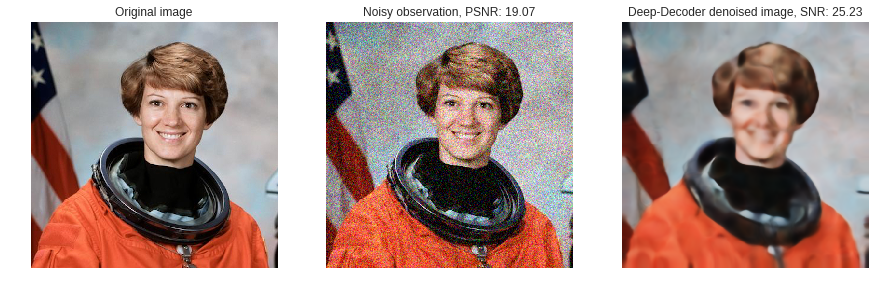

In [18]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))

def plot_results(out_img_np,img_np,img_noisy_np):
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,img_noisy_np)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3,out_img_np)
    ax3.set_title( "Deep-Decoder denoised image, SNR: %.2f" % psnr(img_np,out_img_np) ) 
    ax3.axis('off')    

    plt.show()
     
img_noisy_np,img_noisy_var = get_noisy_img(sig=30,noise_same = False)
out_img_np, mse_t = denoise(img_noisy_var,k=128,numit = 100,rn = 0.0)

plot_results(out_img_np,img_np,img_noisy_np)

shape:  [1, 128, 16, 16]
optimize with adam 0.01


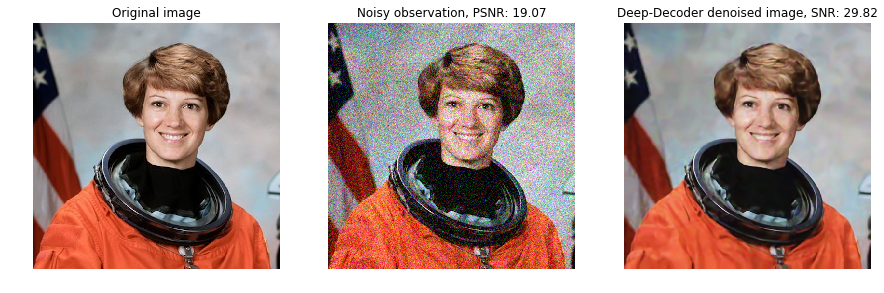

In [0]:
img_noisy_np,img_noisy_var = get_noisy_img(sig=30,noise_same = False)
out_img_np, mse_t = denoise(img_noisy_var,k=128,numit = 10000,rn = 0.015,upsample_first = False)

plot_results(out_img_np,img_np,img_noisy_np)

## Choice of number of layers

The number of layers $k$ is a hyperparameter that enables trading off amount of noise that is removed versus the representation error by the model. 
Smaller $k$ remove more of the noise, but also increase the error of approximating an image with the deep decoder. The optimal choise of $k$ depends on the noise level. To illustrate this consider the experiment below.

The following series of plots show the PSNR of the output of the deep decoder during training as a function of iteration number.  The blue curves correspond to k=32, the orange corresponds to k = 64, and the green corresponds to k = 128.

In [0]:
def best_k(ks,sig=70,numit=400,noise_same = False,find_best=True):
    img_noisy_np,img_noisy_var = get_noisy_img(sig=sig,noise_same = noise_same)
    print("Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np))
    mses = []
    psnrs = []
    for k in ks:
        out_img_np, mse_t = denoise(img_noisy_var,k=k,numit = numit,rn = 0.0)
        psnrs += [psnr(img_np,out_img_np)]
        mses  += [mse_t]
    plt.yscale('log')
    plt.xscale('log')
    for mse_t in mses:
        plt.plot(mse_t)
    plt.show()
    print(psnrs)

### If we regularize with the model alone, and run close to convergence, $64$ performs best:

Noisy observation, PSNR: 20.56
shape:  [1, 32, 16, 16]
optimize with adam 0.01
shape:  [1, 64, 16, 16]n loss 0.009729  Actual loss 0.001851 Actual loss orig 0.001851  Noise Energy 0.008788 
optimize with adam 0.01
shape:  [1, 128, 16, 16] loss 0.008613  Actual loss 0.001384 Actual loss orig 0.001384  Noise Energy 0.008788 
optimize with adam 0.01


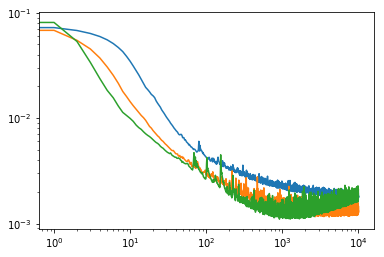

[27.496662276852128, 29.17647720868148, 28.005600787397952]


In [0]:
ks = [32,64,128]
best_k(ks,sig=25,numit=10000,noise_same=True)

### If we additionally stop early to regularize, then $k=128$ performs best:

Noisy observation, PSNR: 20.56
shape:  [1, 32, 16, 16]
optimize with adam 0.01
shape:  [1, 64, 16, 16]n loss 0.010036  Actual loss 0.002020 Actual loss orig 0.002020  Noise Energy 0.008796 
optimize with adam 0.01
shape:  [1, 128, 16, 16] loss 0.008953  Actual loss 0.001393 Actual loss orig 0.001393  Noise Energy 0.008796 
optimize with adam 0.01


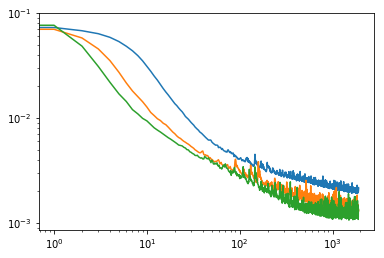

[27.173206495860143, 28.947806778900883, 29.497739520718714]


In [0]:
ks = [32,64,128]
best_k(ks,sig=25,numit=1900,noise_same=True)

### More noise requires more regularization, either by using a smaller $k$:

Noisy observation, PSNR: 13.70
shape:  [1, 32, 16, 16]
optimize with adam 0.01
shape:  [1, 64, 16, 16]n loss 0.041353  Actual loss 0.004360 Actual loss orig 0.004360  Noise Energy 0.042637 
optimize with adam 0.01
shape:  [1, 128, 16, 16] loss 0.038342  Actual loss 0.004828 Actual loss orig 0.004828  Noise Energy 0.042637 
optimize with adam 0.01


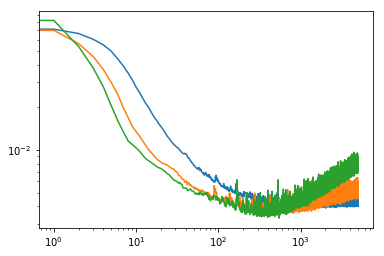

[23.97152797771778, 23.13213975527239, 21.707623440058754]


In [0]:
ks = [32,64,128]
best_k(ks,sig=60,numit=5000,noise_same=True)

### ... or by stopping even earlier:

Noisy observation, PSNR: 13.69
shape:  [1, 32, 16, 16]
optimize with adam 0.01
shape:  [1, 64, 16, 16]n loss 0.042201  Actual loss 0.004362 Actual loss orig 0.004362  Noise Energy 0.042717 
optimize with adam 0.01
shape:  [1, 128, 16, 16] loss 0.040556  Actual loss 0.004071 Actual loss orig 0.004071  Noise Energy 0.042717 
optimize with adam 0.01


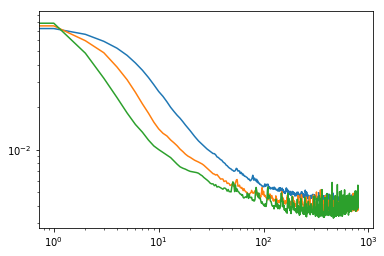

[23.79666305521782, 24.373469101468615, 24.036226737614193]


In [0]:
ks = [32,64,128]
best_k(ks,sig=60,numit=800,noise_same=True)